**Splitting**

In [ ]:
import hashlib
from typing import Tuple, List

class Experiment:
    """Experiment class. Contains the logic for assigning users to groups."""

    def __init__(
        self,
        experiment_id: int,
        groups: Tuple[str, ...] = ("A", "B"),
        group_weights: List[float] = None,
    ):
        self.experiment_id = experiment_id
        self.groups = groups

        # Соль для эксперимента — что-то уникальное и определяемое по experiment_id
        self.salt = f"experiment_{experiment_id}"

        # Если веса не заданы — равные веса
        num_groups = len(self.groups)
        if group_weights is None:
            self.group_weights = [1.0 / num_groups] * num_groups
        else:
            if len(group_weights) != num_groups:
                raise ValueError("group_weights length must match groups length")
            if any(w < 0 for w in group_weights):
                raise ValueError("group_weights must be non-negative")
            total = sum(group_weights)
            # Нормализуем веса чтобы сумма была 1
            self.group_weights = [w / total for w in group_weights]
            # Или можно: if abs(sum(self.group_weights) - 1.0) > 1e-8: raise ...

        # Предвычислим кумулятивные веса для быстрого поиска группы
        cum_sum = 0.0
        self.cum_group_weights = []
        for w in self.group_weights:
            cum_sum += w
            self.cum_group_weights.append(cum_sum)
        # Последний всегда 1.0

    def group(self, click_id: int) -> Tuple[int, str]:
        """Assigns a click to a group."""
        # Готовим строку для хэша — соль + click_id (чтобы распределение для каждого эксперимента уникально)
        hash_input = f"{self.salt}_{click_id}".encode("utf-8")
        digest = hashlib.sha256(hash_input).digest()
        # Преобразуем первые 8 байт в число
        number = int.from_bytes(digest[:8], "big")
        # [0, 1)
        x = number / 2**64

        # Ищем в какой диапазон кумулятивных весов попал x — O(N) или bisect если групп много
        for idx, upper in enumerate(self.cum_group_weights):
            if x < upper:
                return idx, self.groups[idx]
        # Фолбэк — на всякий случай (теоретически не должен понадобиться)
        idx = len(self.groups) - 1
        return idx, self.groups[idx]

In [ ]:
class Experiment:
    """Experiment class. Contains the logic for assigning users to groups."""

    def __init__(
        self,
        experiment_id: int,
        groups: Tuple[str] = ("A", "B"),
        group_weights: List[float] = None,
    ):
        self.experiment_id = experiment_id
        self.groups = groups
        self.group_weights = group_weights

        # Define the salt for experiment_id.
        # The salt should be deterministic and unique for each experiment_id.

        #Определите значение для идентификатора experiment_id.
        # Значение должно быть детерминированным и уникальным для каждого идентификатора experiment_id.
        self.salt = experiment_id
        # Define the group weights if they are not provided equaly distributed
        # Check input group weights. They must be non-negative and sum to 1.

        # # Определите веса групп, если они распределены неравномерно
        # Проверьте веса входных групп. Они должны быть неотрицательными и в сумме давать 1.
        num_groups = len(self.groups)
        if group_weights is None:
          self.group_weights = [1.0/num_groups] * num_groups
          if group_weights != num_groups:
            raise ValueError("group_weights length must match groups length")
          if any(w<0 for w in group_weights):
            raise ValueError("group_weights must be non-negative")
          total = sum(group_weights)

        self.group_weights = [w/total for w in group_weights]

        cum_sum = 0.0
        self.cum_group_weights = []
        for w in self.group_weights:
          cum_sum += w
          self.cum_group_weights.append(cum_sum)

    def group(self, click_id: int) -> Tuple[int, str]:
        """Assigns a click to a group.

        Parameters
        ----------
        click_id: int :
            id of the click

        Returns
        -------
        Tuple[int, str] :
            group id and group name
        """

        # Assign the click to a group randomly based on the group weights
        # Присвоить клик группе случайным образом в зависимости от веса группы
        # Вернуть идентификатор группы и название группы
        # Return the group id and group name
        hash = f"{self.salt}_{click_id}".encode("utf-8")
        digest = hashlib.sha256(hash_input).digest() #-> Получаем хеш, например (в hex): a1b2c3d4e5f6... (первые 8 байт = a1b2c3d4e5f6g7)
        # теперь нам надо преобразовать хэш в число
        # Преобразуем первые 8 байт в число
        number = int.from_bytes(digest[:8], "big")
        # [0, 1)
        x = number / 2**64

        for group_id,upper in enumerate(self.cum_group_weights):
          if x < upper:
            return group_id,upper

        # Фолбэк — на всякий случай (теоретически не должен понадобиться)
        group_id = len(self.groups) - 1
        return group_id, self.groups[group_id]

**Statistical test**

1. CVR (conversion rate) — конверсия совершения действия (action) пользователем

2. CPA (cost-per-action) — плата за действие

3. CPC (cost-per-click) — плата за клик. Рассчитывается как CVR * CPA



1. Смоделировать CVR, используя биномиальное распределение. **На выходе мы хотим получить массив 0 и 1 (было совершено действие action или нет)**, где количество единиц появляется с определенной конверсией (вероятностью) conversion_rate.
2. Смоделировать CPA из нормального распределения с параметрами (reward_avg — среднее значение и reward_std — стандартное отклонение).
3. Рассчитать CPC по формуле выше. - CPC (cost-per-click) — плата за клик. Рассчитывается как CVR * CPA

Функция принимает на вход размер выборки n_samples, конверсию conversion_rate, среднее значение и стандартное отклонение вознаграждения за action reward_avg и reward_std .

In [ ]:
def cpc_sample(
    n_samples: int, conversion_rate: float, reward_avg: float, reward_std: float
) -> np.ndarray:
    """Sample data."""
    cvr = np.random.binomial(1,conversion_rate,size=n_samples)
    cpa = np.random.normal(loc=reward_avg, scale=reward_std, size=n_samples)
    cpc = cvr * cpa
    return cpc

Статистический критерий – конкретный статистический тест, используемый для принятия решения, есть ли различие между группами. Например, **популярный t-тест, который проверяет, отличается ли среднее двух выборок или нет.**

1. p-value — это вероятность получить такое же значение статистики или более экстремальное, при условии, что нулевая гипотеза верна.

На вход функция принимает две выборки и уровень значимости alpha. Возвращает True, если различие между выборками статистически значимо и False, если нет. А также значение p-value.

In [ ]:
from typing import Tuple
import numpy as np
from scipy.stats import ttest_ind

def t_test(
    cpc_a: np.ndarray, cpc_b: np.ndarray, alpha=0.05
) -> Tuple[bool, float]:
    """Perform t-test for two independent samples.
    Returns: (True if difference is significant, p-value)
    """
    stat, p_value = ttest_ind(cpc_a, cpc_b, equal_var=False)
    is_significant = bool(p_value < alpha)  # <--- явное приведение типа
    return is_significant, float(p_value)   # <--- явное приведение типа

In [ ]:
pythonfrom typing import Tuple
import numpy as np
from scipy.stats import t as t_dist

def t_test(cpc_a: np.ndarray, cpc_b: np.ndarray, alpha=0.05
) -> Tuple[bool, float]:
    """t-test реализованный вручную (Уэлча)"""
    n_a, n_b = len(cpc_a), len(cpc_b)
    mean_a, mean_b = np.mean(cpc_a), np.mean(cpc_b)
    var_a = np.var(cpc_a, ddof=1)  # несмещенная дисперсия
    var_b = np.var(cpc_b, ddof=1)

    # t-статистика
    numerator = mean_a - mean_b
    denominator = np.sqrt(var_a / n_a + var_b / n_b)
    t_stat = numerator / denominator

    # Степени свободы по формуле Уэлча
    df_num = (var_a / n_a + var_b / n_b) ** 2
    df_den = ((var_a / n_a) * 2) / (n_a - 1) + ((var_b / n_b) * 2) / (n_b - 1)
    df = df_num / df_den

    # p-value (двусторонний тест)
    p_value = 2 * t_dist.sf(np.abs(t_stat), df)
    is_significant = p_value < alpha
    return is_significant, p_value

**Simulated A/A-test**

Проведем простую симуляцию. Сгенерируем двe CPC выборки с одинаковыми характеристиками и проведем t-тест. Другими словами мы симулируем тест между двумя группами, когда заведомо известно, что между группами нет никаких различий. **Такие тесты, когда между группами заведомо нет различий, называются A/A-тестами.**

Дополнительно **к уже известным параметрам функция принимает на вход n_simulations — количество симуляций** (в каждой симуляции генерируем две подобные выборки и сравниваем с помощью t_test. Результат функции — это доля симуляций, где t_test зафиксировал различие.

In [3]:
from typing import Tuple
import numpy as np
from scipy.stats import ttest_ind

def cpc_sample(
    n_samples: int, conversion_rate: float, reward_avg: float, reward_std: float
) -> np.ndarray:
    """Sample data."""
    cvr = np.random.binomial(1,conversion_rate,size=n_samples)
    cpa = np.random.normal(loc=reward_avg, scale=reward_std, size=n_samples)
    cpc = cvr * cpa
    return cpc

def t_test(
    cpc_a: np.ndarray, cpc_b: np.ndarray, alpha=0.05
) -> Tuple[bool, float]:
    """Perform t-test for two independent samples.
    Returns: (True if difference is significant, p-value)
    """
    stat, p_value = ttest_ind(cpc_a, cpc_b, equal_var=False)
    is_significant = bool(p_value < alpha)  # <--- явное приведение типа
    return is_significant, float(p_value)   # <--- явное приведение типа

def aa_test(
        n_simulations: int,
        n_samples: int,
        conversion_rate: float,
        reward_avg: float,
        reward_std: float,
        alpha: float = 0.05,
) -> float:
    """Do the A/A test (simulation)."""

    type_1_errors = 0
    for _ in range(n_simulations):  # '_' вместо 'i', если не используется
        # Generate two cpc samples with the same parameters
        cpc_1 = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        cpc_2 = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)

        # Check t-test and save type 1 error
        is_significant, _ = t_test(cpc_1, cpc_2, alpha=alpha)  # '_' вместо 'p_value', если не используется
        if is_significant:
            type_1_errors += 1
    type_1_errors_rate = type_1_errors / n_simulations

    return type_1_errors_rate

Если A/A-тест проведен корректно (выборки независимые, между ними нет явных различий, они достаточного размера), то доля ошибок I рода будет примерно равна уровню значимости α. Такие A/A-тесты полезно проводить на этапе дизайна A/B эксперимента, чтобы оценить, что наш тест спроектирован правильно.

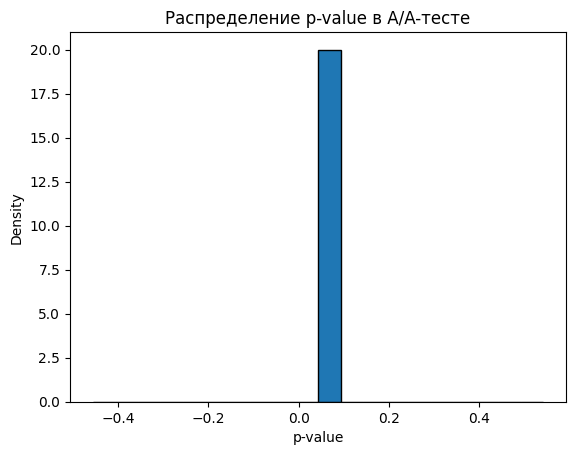

In [5]:
import matplotlib.pyplot as plt


p_values = aa_test(
    n_simulations=1000,
    n_samples=100,
    conversion_rate=0.1,
    reward_avg=10,
    reward_std=2
)

plt.hist(p_values, bins=20, edgecolor='k', density=True)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('Распределение p-value в A/A-тесте')
plt.show()

На графике показано распределение p-value в A/A-тесте. Это означает, что обе группы теста идентичны, и мы не ожидаем увидеть значимых отличий между ними.  

**Simulated A/B-test**

Реализуйте новую функцию ab_test. Функция должна много раз (n_simulations) генерировать две CPC выборки. **Конверсия во второй выборке отличается от конверсии в первой выборке на размер MDE.**

**MDE (minimal detectable effect)** — **минимальный эффект, который мы можем поймать.** Параметр задается как относительное увеличение. Если мы хотим ловить изменение reward_avg в 10%, то значение параметра указывается в виде MDE = 0.1.

По дизайну мы знаем, что наши выборки отличаются. Поэтому каждый раз, когда тест фиксирует отличия между выборками — это правильно. **Когда тест не фиксирует отличий, мы фиксируем ошибку II рода. Функция должна вернуть долю таких ошибок.**

Мощностью теста (или чувствительностью) называют вероятность, с которой мы будем фиксировать нужный нам MDE. Мощность рассчитывают как **1 - β**.

Чем больше чувствительность теста, тем меньше ошибок будет совершаться и меньшие эффекты можно фиксировать. Плюс потребуется меньше данных и тест можно провести быстрее. В индустрии повышению чувствительности тестов уделяется большое внимание.
Потому что:
1. чем больше **тестов мы сможем провести за одно и то же время, тем больше гипотез сможем протестировать и больше изменений внедрить, заработать больше денег**;
2. чем **более незначительные эффекты мы сможем фиксировать, тем больше денег сможем заработать для компании.** Эффект в 1% на оборотах в миллиарды рублей (или долларов) принесет дополнительных 10 миллионов.

In [8]:
def ab_test(
    n_simulations: int,
    n_samples: int,
    conversion_rate: float,
    mde: float,
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
) -> float:
    """Do the A/B test (simulation)."""

    type_2_errors = 0
    conversion_rate_b = conversion_rate * (1 + mde)
    for i in range(n_simulations):
        # Generate one cpc sample with the given conversion_rate, reward_avg, and reward_std
        cpc_1 = cpc_sample(n_samples, conversion_rate, reward_avg, reward_std)
        cpc_2 = cpc_sample(n_samples, conversion_rate_b, reward_avg, reward_std)

        # Generate another cpc sample with the given conversion_rate * (1 + mde), reward_avg, and reward_std
        # Check t-test and save type 2 error
        ## Ошибка II рода -- если тест НЕ обнаружил значимых отличий там, где они на самом деле есть
        is_significant, _ = t_test(cpc_1, cpc_2, alpha=alpha)  # '_' вместо 'p_value', если не используется
        if not is_significant:
            type_2_errors += 1
    type_2_errors_rate = type_2_errors / n_simulations

    return type_2_errors_rate

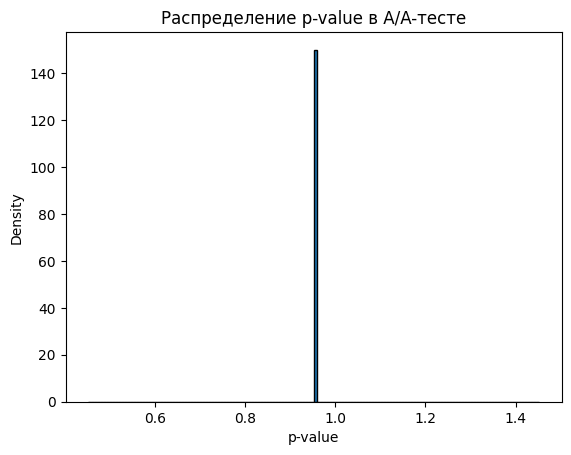

In [9]:
import matplotlib.pyplot as plt


p_values = ab_test(
    n_simulations=1000,
    n_samples=100,
    conversion_rate=0.1,
    mde = 0.1,
    reward_avg=10,
    reward_std=2
)

plt.hist(p_values, bins=150, edgecolor='k', density=True)
plt.xlabel('p-value')
plt.ylabel('Density')
plt.title('Распределение p-value в A/A-тесте')
plt.show()

In [12]:
# Импортируем необходимые библиотеки и функции
from typing import Tuple
import numpy as np
from scipy.stats import ttest_ind

# Вставь сюда свои определения функций: cpc_sample, t_test, aa_test, ab_test

# Зададим параметры эксперимента
n_simulations = 1000
n_samples = 1000
conversion_rate = 0.1
mde = 0.2  # Искомое минимальное детектируемое отличие (например, +10%)
reward_avg = 1000
reward_std = 10
alpha = 0.05   # Уровень значимости

# Проведем A/A тест: насколько часто находим различие, когда его НЕТ
type_1_error = aa_test(
    n_simulations=n_simulations,
    n_samples=n_samples,
    conversion_rate=conversion_rate,
    reward_avg=reward_avg,
    reward_std=reward_std,
    alpha=alpha
)

print(f"A/A тест: Ошибка I рода (False Positive Rate) = {type_1_error:.3f}")

# Проведем A/B тест: насколько часто НЕ находим различие, когда оно ЕСТЬ
type_2_error = ab_test(
    n_simulations=n_simulations,
    n_samples=n_samples,
    conversion_rate=conversion_rate,
    mde=mde,
    reward_avg=reward_avg,
    reward_std=reward_std,
    alpha=alpha
)

print(f"A/B тест: Ошибка II рода (False Negative Rate) = {type_2_error:.3f}")
print(f"Мощность теста (power) = {1 - type_2_error:.3f}")


A/A тест: Ошибка I рода (False Positive Rate) = 0.049
A/B тест: Ошибка II рода (False Negative Rate) = 0.698
Мощность теста (power) = 0.302


Мощность теста (statistical power, power of a test) — это вероятность обнаружить реальное различие между группами, если оно действительно существует.

Иначе говоря, это вероятность **правильно отвергнуть** нулевую гипотезу, когда альтернатива истинна (найти эффект, если он есть).

**Sample size, MDE**

Теперь настало время рассчитать, какой же размер групп нам нужен в предстоящем эксперименте.

Один из самых наглядных и универсальных способов определить sample size (или MDE) — это подобрать экспериментально. У нас есть написанный код для симуляций и проведения **A/A и A/B тестов**. Давайте просто будем передавать в эти функции разные значения n_samples или MDE, и выберем такие значения, при которых доля ошибок I и II рода будет в пределах нужных нам уровней.

- Ошибка I рода (alpha) — вероятность ошибиться, когда отличие несуществует («нашли эффект, которого нет»).
- Ошибка II рода (beta) — вероятность ошибиться, когда отличие есть, но его не нашли.

- В обычной практике, alpha (уровень значимости) ставят 0.05 или 0.01 — это максимально допустимая ошибка I рода.
- beta (принимаемый риск пропустить эффект) ставят 0.2 (мощность теста 80%), реже 0.1 или 0.05.

- В обычной практике, alpha (уровень значимости) ставят 0.05 или 0.01 — это максимально допустимая ошибка I рода.
- beta (принимаемый риск пропустить эффект) ставят 0.2 (мощность теста 80%), реже 0.1 или 0.05.

In [ ]:
from typing import List, Tuple
import numpy as np
from scipy import stats

def select_sample_size(
    n_samples_grid: List[int],
    n_simulations: int,
    conversion_rate: float,
    mde: float,
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
    beta: float = 0.2,
) -> Tuple[int, float, float]:
    """Select sample size."""
    for n_samples in n_samples_grid:
      type_1_error = aa_test(
            n_simulations, n_samples, conversion_rate, reward_avg, reward_std, alpha=alpha
        )
      type_2_error = ab_test(
            n_simulations, n_samples, conversion_rate, mde, reward_avg, reward_std, alpha=alpha
        )
      if (type_1_error <= alpha) and (type_2_error <= beta):
        return n_samples, type_1_error, type_2_error

    raise RuntimeError(
        "Can't find sample size. "
        f"Last sample size: {n_samples}, "
        f"last type 1 error: {type_1_error}, "
        f"last type 2 error: {type_2_error}"
        "Make sure that the grid is big enough."
    )


def select_mde(
    n_samples: int,
    n_simulations: int,
    conversion_rate: float,
    mde_grid: List[float],
    reward_avg: float,
    reward_std: float,
    alpha: float = 0.05,
    beta: float = 0.2,
) -> Tuple[float, float]:
    """Select MDE."""
    for mde in mde_grid:
        type_2_error = ab_test(
            n_simulations, n_samples, conversion_rate, mde, reward_avg, reward_std, alpha=alpha
        )
        if type_2_error <= beta:
            return mde, type_2_error

    raise RuntimeError(
        "Can't find MDE. "
        f"Last MDE: {mde}, "
        f"last type 2 error: {type_2_error}. "
        "Make sure that the grid is big enough."
    )

**Формулы для Sample size и MDE**

Если **ваши данные распределены нормально** (напомню, что наше распределение cpc не похоже на нормальное), то для расчета sample size и MDE можно воспользоваться формулами.

**z**— это **функция обратной нормальной функции распределения** (или функция инверсии нормального распределения). Она используется для определения квантиля нормального распределения. Функция инверсии нормального распределения дает нам значение x, для которого соответствующая вероятность равна заданному значению.

In [ ]:
import numpy as np
from scipy import stats
from scipy.stats import norm

def calculate_sample_size(
    reward_avg: float, reward_std: float, mde: float, alpha: float, beta: float
) -> int:
    """Calculate sample size.

    Parameters
    ----------
    reward_avg: float :
        average reward
    reward_std: float :
        standard deviation of reward
    mde: float :
        minimum detectable effect
    alpha: float :
        significance level
    beta: float :
        type 2 error probability

    Returns
    -------
    int :
        sample size

    """
    assert mde > 0, "mde should be greater than 0"

    mde_abs = mde * reward_avg
    variance = reward_std ** 2

    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(1 - beta)

    numerator = (z_alpha + z_beta) ** 2 * 2 * variance
    denominator = mde_abs ** 2

    sample_size = int(np.ceil(numerator / denominator))
    return sample_size


def calculate_mde(
    reward_std: float, sample_size: int, alpha: float, beta: float
) -> float:
    """Calculate minimal detectable effect."""
    assert sample_size > 0, "sample_size should be greater than 0"

    z_alpha = stats.norm.ppf(1 - alpha / 2)
    z_beta = stats.norm.ppf(1 - beta)

    mde = (z_alpha + z_beta) * reward_std * np.sqrt(2 / sample_size)
    return mde